# Extract the dominant colors of skin, eyes and hair

In [82]:
import cv2
import numpy as np
import dlib
import Queue
import matplotlib.pyplot as plt
import glob
import time
from collections import OrderedDict
from IPython.core.debugger import Tracer
%matplotlib inline

In [83]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
    #("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)), # hair
    #("left_eyebrow", (22, 27)),
    #("left_eye", (42, 48)),
    ("nose", (27, 35)), # skin
    ("right_eye", (36, 42)), # eye
    #("jaw", (0, 17))
])

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

# Image is already a face no need to extract the face
def extract_face_parts(image, predictor_path):
    predictor = dlib.shape_predictor(predictor_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rect = dlib.rectangle(left=0, top=0, right=image.shape[1], bottom=image.shape[0])
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    
    rois = []

    for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
        rois.append((x, y, w, h))
        
    # reduce height of nose
    nose = rois[1]
    nose_h = int(nose[3] * 0.75)
    nose = (nose[0], nose[1], nose[2], nose_h)
    rois[1] = nose
    
#     cascade_path = 'haarcascade_eye_tree_eyeglasses.xml'
#     eye_cascade = cv2.CascadeClassifier(cascade_path)
    
#     eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
#     if len(eyes) > 0:
#         (x, y, w, h) = eyes[0]
#         rois.append((x, y, w, h))
        
    return rois

In [187]:
# eye is square and grayscale
def find_eye_center(eye, stdDevFactor=50):
    gradient_x = np.diff(eye)[:-1, :]
    gradient_y = np.diff(eye.T)[:-1, :].T
    
    flat_x = gradient_x.ravel()
    flat_y = gradient_y.ravel()
    
    magnitude = np.sqrt(np.square(flat_x) + np.square(flat_y)).reshape(gradient_x.shape)
    
    mean, std = cv2.meanStdDev(magnitude.astype(float))

    stdDev = std.ravel()[0] / np.sqrt(magnitude.shape[0] * magnitude.shape[1])
    
    gradientThresh = stdDevFactor * stdDev + mean.ravel()[0]
    
    isMagnitude = magnitude > gradientThresh
    gradient_x[~isMagnitude] =  0
    gradient_y[~isMagnitude] =  0
    
    return gradient_x, gradient_y

def test_possible_centers(boolean_gradients, weight_eye, gx, gy, kEnableWeight = True, kWeightDivisor = 1):
    assert len(weight_eye) == len(gx) == len(gy)
    
    sum_ = np.zeros(weight_eye.shape).astype(float)
    
    # indices of gradients
    yi, xi = np.where(boolean_gradients == True)
    
    h, w = weight_eye.shape
    xpos = np.tile(np.arange(w), h).reshape(h, w)
    ypos = np.tile(np.arange(h), w).reshape(w, h).T
    
    for x, y in zip(xi, yi):
#         print("x, y: {:d}, {:d}".format(x, y))
        cxpos = np.tile((np.zeros(w) + x), h).reshape(h, w)
        cypos = np.tile((np.zeros(h) + y), w).reshape(w, h).T
        
        xdis = xpos - cxpos
        ydis = ypos - cypos
        
        xdis = xdis + 0.001 # avoid division by 0
        ydis = ydis + 0.001
        
        flat_x = xdis.ravel()
        flat_y = ydis.ravel()
    
        magnitude = np.sqrt(np.square(flat_x) + np.square(flat_y)).reshape(xdis.shape)
        xdis = xdis / magnitude
        ydis = ydis / magnitude
                
        dotProduct = xdis * gx + ydis * gy
        dotProduct[dotProduct < 0] = 0
        
        if kEnableWeight:
            new_sum = dotProduct * dotProduct * (weight_eye / kWeightDivisor)
            sum_ = sum_ + new_sum
        else:
            new_sum = dotProduct * dotProduct
            sum_ = sum_ + new_sum
    
    return sum_

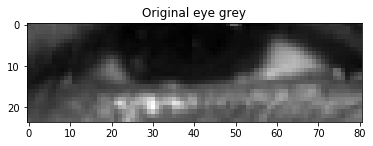

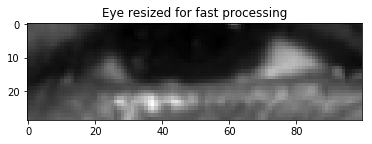

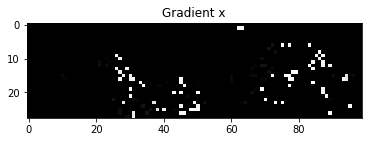

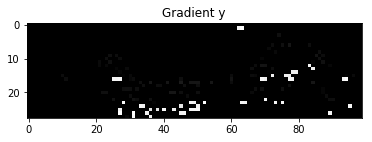

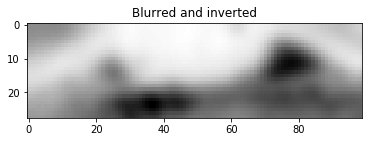

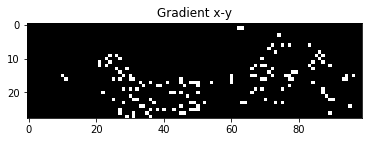

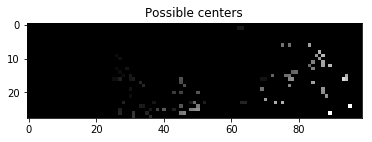

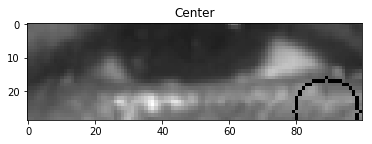

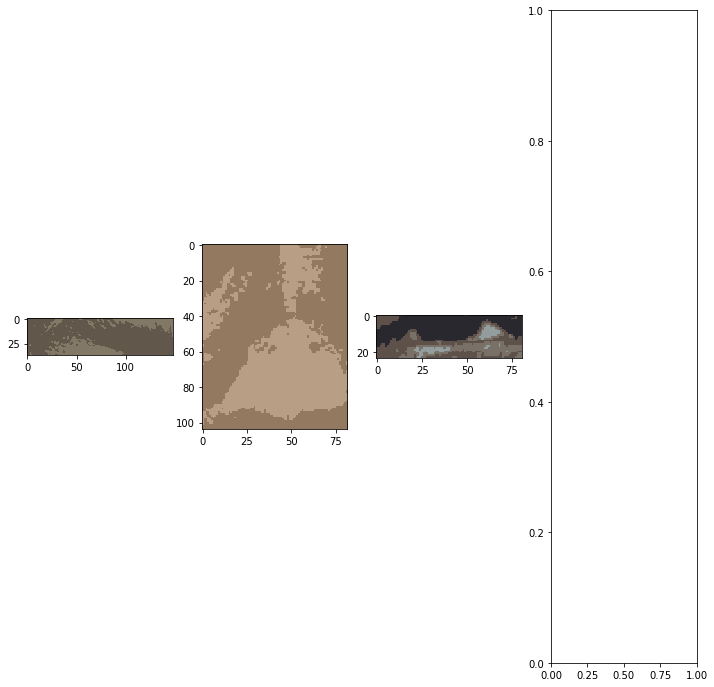

In [188]:
def try_it(face_path):
        
    image = cv2.imread(face_path)
    image2 = cv2.imread(face_path)
    image_f = image.astype(float)
    rois = extract_face_parts(image, "shape_predictor_68_face_landmarks.dat")

#     plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
#     plt.figure()
    
    # detect pupil with Hough 
    (ex, ey, w, h) = rois[2]
    eye = image[ey:ey + h, ex:ex + w, :]
    #eye = cv2.resize(eye, (eye.shape[1] * 2, eye.shape[0] * 2))
    geye = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(geye)
    
    circles = cv2.HoughCircles(equ,cv2.HOUGH_GRADIENT,1,100, \
                            param1=50,param2=10,minRadius=15,maxRadius=28)
    circles = np.uint16(np.around(circles))
    
    center = int(eye.shape[0] / 2)
    offset = int(eye.shape[0] * 0.1)
    cop = center + offset
    con = center - offset
    
    assert len(circles) == 1
    
#     for i in circles[0,:]:
        
#         #if i[0] < cop and i[0] > con and i[1] < cop and i[1] > con:
        # draw the outer circle
#         cv2.circle(geye,(i[0],i[1]),i[2],(0,255,0),1)
        # draw the center of the circle
#         cv2.circle(geye,(i[0],i[1]),2,(0,0,255),1)
        
#         (x, y, w, h) = (i[1] - i[2], i[0] - i[2], 2 * i[2], 2 * i[2])
        
#         iris = geye[x:x+w, y:y+h]
#         plt.imshow(iris, cmap='gray')
#         plt.figure()
        
#         rois[2] = (ex + x, ey + y, w, h)
    
    plt.imshow(geye, cmap='gray')
    plt.title("Original eye grey")
    plt.figure()
    ###########################
    # Resize
    kConstantSize = 2
    kFastEyeWidth = 50 * kConstantSize
    h, w = geye.shape
    geye = cv2.resize(geye, (kFastEyeWidth, kFastEyeWidth * h / w))
    plt.imshow(geye, cmap='gray')
    plt.title("Eye resized for fast processing")
    plt.figure()
    
    # Gradients
    kGradientThreshold = 50 * kConstantSize
    gx, gy = find_eye_center(geye, kGradientThreshold)
    plt.imshow(gx, cmap='gray')
    plt.title("Gradient x")
    plt.figure()
    plt.imshow(gy, cmap='gray')
    plt.title("Gradient y")
    plt.figure()
    
    # Blur and inverted
    kWeightBlurSize = 5 * kConstantSize + 1
    gaussian_eye = cv2.GaussianBlur(geye, (kWeightBlurSize, kWeightBlurSize), 0)
    weight_eye = 255 - gaussian_eye
    weight_eye = weight_eye[:-1,:-1] # remove last column & row just for convenience
    plt.imshow(weight_eye, cmap='gray')
    plt.title("Blurred and inverted")
    plt.figure()

    # Possible centers
    gxt = gx > 0
    gyt = gy > 0
    gtt = gxt * gyt
    
    zeros = np.zeros(weight_eye.shape)
    zeros[gtt] = 255
    
    plt.imshow(zeros, cmap='gray')
    plt.title("Gradient x-y")
    plt.figure()
    
    kEnableWeight = True
    kWeightDivisor = 0.5
    weight_eye = weight_eye.astype(float)
    sum_ = test_possible_centers(gtt, weight_eye, gx, gy, kEnableWeight, kWeightDivisor)
    plt.imshow(sum_, cmap='gray')
    plt.title("Possible centers")
    plt.figure()
    
    # Max point
    h, w = weight_eye.shape
    numGradients = h * w
    sum_ =  sum_ / numGradients
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(sum_)
    cv2.circle(geye, maxLoc, 10, (0,255,0), 1)
    
    plt.imshow(geye, cmap='gray')
    plt.title("Center")
    plt.figure()
    
    ###########################
    
    l = len(rois)
    assert l == 3
    f, ax = plt.subplots(1, 4, figsize = (12, 12))
    for K, roi, title, i in zip([2, 2, 4], rois, ["eyebrow", "nose", "eye"], range(l)):
        (x, y, w, h) = roi

        part = image[y:y + h, x:x + w, :]
        Z = part.reshape((-1, 3))
        Z = np.float32(Z)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((part.shape))

        ax[i].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
        cv2.rectangle(image2, (x, y), (x+w, y+h), (0, 255, 0), 1)
    
try_it("1.ppm")
# try_it("2.ppm")
# try_it("3.ppm")
# try_it("4.ppm")
       